<a href="https://colab.research.google.com/github/NU-MSE-LECTURES/465-WINTER2026/blob/main/Week_02/assignments/assignment_02_setup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 02: 4D-STEM Foundations

Complete this assignment to demonstrate your understanding of 4D-STEM data analysis and calibration.


In [208]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import hyperspy.api as hs
import py4DSTEM as py4D
import pyUSID

from scipy.ndimage import fourier_shift
from numpy.fft import fft2, ifft2


print(np.__version__)

print(hs.__version__)
print(py4D.__version__)
print(pyUSID.__version__)
print(sidpy.__version__)

1.26.4
2.3.0
0.14.18
0.0.12
0.12.8


## Task 1: Distinguish Navigation vs. Signal Axes

In your notebook, define the "Navigation Axes" (where the measurement is made, e.g., x, y scan positions).

Define the "Signal Axes" (what is measured at each point, e.g., an EELS spectrum or a 2D diffraction pattern).

Use signal.axes manager to print and verify the dimensionality of a 4D-STEM dataset (expected: 2 Navigation, 2 Signal).

In [209]:
#Define Navigation Axes 

#load file 
signal_1 = hs.load('/Users/jfj3094/Documents/MATSCI465_VALERIA_RODRIGUEZ/assignment_02_output/data/raw/Diffraction SI_Au_Calib.dm4')
signal_2a = hs.load('/Users/jfj3094/Documents/MATSCI465_VALERIA_RODRIGUEZ//assignment_02_output/data/raw/Si-SiGe.dm4')

#Print Axes Manager, which has Name, size, scale, units
print(f"Shape: {signal_1.axes_manager}")
print(f"Shape: {signal_2a.axes_manager}")


Shape: <Axes manager, axes: (20, 20|256, 256)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
               z |     20 |      0 |      -0 |   0.002 |     µm 
     <undefined> |     20 |      0 |      -0 |   0.002 |     µm 
---------------- | ------ | ------ | ------- | ------- | ------ 
               x |    256 |      0 |     -34 |    0.27 |   1/nm 
               y |    256 |      0 |     -34 |    0.27 |   1/nm 
Shape: <Axes manager, axes: (448, 480|17, 77)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
               z |    448 |      0 |       0 |   0.062 |   1/nm 
     <undefined> |    480 |      0 |       0 |   0.062 |   1/nm 
---------------- | ------ | ------ | ------- | ------- | ------ 
               x |     17 |      0 |       0 |       2 |     nm 
               y |     77 |      0 |       0 |       2 |     

In [210]:
#Diffraction but first

#fix the x,y, Qx, Qy

# Set navigation axes (scan positions)

#Diffraction SI

signal_1.axes_manager.navigation_axes[0].name = "x"
signal_1.axes_manager.navigation_axes[0].units = "µm"
signal_1.axes_manager.navigation_axes[0].scale = 0.002

signal_1.axes_manager.navigation_axes[1].name = "y"
signal_1.axes_manager.navigation_axes[1].units = "µm"
signal_1.axes_manager.navigation_axes[1].scale = 0.002


# Signal axes (diffraction)
signal_1.axes_manager.signal_axes[0].name = "kx"
signal_1.axes_manager.signal_axes[0].units = "1/nm"
signal_1.axes_manager.signal_axes[0].scale = 0.27

signal_1.axes_manager.signal_axes[1].name = "ky"
signal_1.axes_manager.signal_axes[1].units = "1/nm"
signal_1.axes_manager.signal_axes[1].scale = 0.27

print(signal_1.axes_manager)


shape = signal_2a.data.shape
axes_sorted = sorted(enumerate(shape), key=lambda x: x[1])
    
nav_indices = [i for i, _ in axes_sorted[:2]]
sig_indices = [i for i, _ in axes_sorted[2:]]

signal_2 = signal_2a.transpose(nav_indices + sig_indices)
    

signal_axes_in_transposed = (len(nav_indices), len(nav_indices)+1)
signal_2 = signal_2a.as_signal2D(signal_axes_in_transposed)

signal_2 = signal_2.as_signal2D(sig_indices)

signal_2.axes_manager.navigation_axes[0].name = "x"
signal_2.axes_manager.navigation_axes[0].units = "nm"
signal_2.axes_manager.navigation_axes[0].scale = 2

signal_2.axes_manager.navigation_axes[1].name = "y"
signal_2.axes_manager.navigation_axes[1].units = "nm"
signal_2.axes_manager.navigation_axes[1].scale = 2

# Signal axes (diffraction)
signal_2.axes_manager.signal_axes[0].name = "kx"
signal_2.axes_manager.signal_axes[0].units = "1/nm"
signal_2.axes_manager.signal_axes[0].scale = 0.062

signal_2.axes_manager.signal_axes[1].name = "ky"
signal_2.axes_manager.signal_axes[1].units = "1/nm"
signal_2.axes_manager.signal_axes[1].scale = 0.062


print(signal_2.axes_manager)



<Axes manager, axes: (20, 20|256, 256)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
               x |     20 |      0 |      -0 |   0.002 |     µm 
               y |     20 |      0 |      -0 |   0.002 |     µm 
---------------- | ------ | ------ | ------- | ------- | ------ 
              kx |    256 |      0 |     -34 |    0.27 |   1/nm 
              ky |    256 |      0 |     -34 |    0.27 |   1/nm 
<Axes manager, axes: (17, 77|480, 448)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
               x |     17 |      0 |       0 |       2 |     nm 
               y |     77 |      0 |       0 |       2 |     nm 
---------------- | ------ | ------ | ------- | ------- | ------ 
              kx |    480 |      0 |       0 |   0.062 |   1/nm 
              ky |    448 |      0 |       0 |   0.062 |   1/nm 


## Task 2: Load and Calibrate 4D-STEM Data

Use py4DSTEM.io.read to load a 4D-STEM dataset (e.g., .dm4 or .h5).

**Note:** The dataset Si-SiGe.dm4 should be available in the raw_data folder.

Set the scan step size (real space calibration) using dataset.set_scan_step_size().

Perform Center of Mass (CoM) correction using dataset.get_diffraction_shifts() to center the unscattered beam.

In [211]:
#Load Dataset with py4DStem

filepath = '/Users/jfj3094/Documents/MATSCI465_VALERIA_RODRIGUEZ/assignment_02_output/data/raw/Si-SiGe.dm4'

try:
    dataset_calib = py4D.io.import_file(filepath)
    print(f"✓ Dataset loaded successfully!")
    print(f"\nDataset information:")
    print(f"  Shape: {dataset_calib.shape} (order: Rx, Ry, Qx, Qy)")
    print(f"  Diffraction pattern size: {dataset_calib.shape[2:]} pixels")
    print(f"  Scan area: {dataset_calib.shape[0]} x {dataset_calib.shape[1]} pixels")
except FileNotFoundError:
    print(f"✗ File not found: {filepath}")
    print("Make sure SI_Au_calib.dm4 is in the raw_data folder")

✓ Dataset loaded successfully!

Dataset information:
  Shape: (480, 448, 77, 17) (order: Rx, Ry, Qx, Qy)
  Diffraction pattern size: (77, 17) pixels
  Scan area: 480 x 448 pixels


In [212]:
#correct Navigation and Signal
#-----------------------------
dataset = dataset_calib

dataset.data = np.transpose(dataset_calib.data, (3, 2, 0, 1))
print(dataset.shape)  # should be (17, 77, 480, 448)
print(f"\nDataset information:")
print(f"  Shape: {dataset.shape} (order: Rx, Ry, Qx, Qy)")
print(f"  Diffraction pattern size: {dataset.shape[2:]} pixels")
print(f"  Scan area: {dataset.shape[0]} x {dataset.shape[1]} pixels")

##Set Pixel Size
#----------------
dataset.calibration.set_R_pixel_size(1.0)  # scan step
dataset.calibration.set_Q_pixel_size(1.0)  # diffraction

(17, 77, 480, 448)

Dataset information:
  Shape: (17, 77, 480, 448) (order: Rx, Ry, Qx, Qy)
  Diffraction pattern size: (480, 448) pixels
  Scan area: 17 x 77 pixels


In [213]:
import numpy as np
from scipy.ndimage import center_of_mass
# Set scan step size (real space calibration)
step_size = 0.1  # in nm (typical for Si-SiGe dataset)
print(f"Scan step size set to: {step_size} nm")

# Store calibration metadata if available
if hasattr(dataset, 'metadata'):
    dataset.metadata['scan_step_size_nm'] = step_size

# Extract dataset dimensions
Rx, Ry, Qx, Qy = dataset.data.shape  # (scan_x, scan_y, diffraction_x, diffraction_y)

# Navigation axes (scan positions)
nav_shape = (Rx, Ry)
# Signal axes (diffraction pattern)
sig_shape = (Qx, Qy)

print(f"\nNavigation shape (Rx, Ry): {nav_shape}")
print(f"Signal shape (Qx, Qy): {sig_shape}")
print("\n--- Performing Center of Mass (CoM) Correction ---")
print("CoM correction centers the unscattered beam for each diffraction pattern.\n")

# Pre-allocate arrays for CoM shifts (same shape as scan)
shifts_x = np.zeros(nav_shape)
shifts_y = np.zeros(nav_shape)

# Loop over all scan positions
for i in range(Rx):        # scan x
    for j in range(Ry):    # scan y
        # Extract 2D diffraction pattern at scan position (i,j)
        dp = dataset.data[i, j, :, :]  # last two axes are diffraction Qx, Qy

        # Compute center of mass for this diffraction pattern
        if np.sum(dp) > 0:
            com_y, com_x = center_of_mass(dp)  # returns (row, column)
        else:
            com_y, com_x = sig_shape[0]/2, sig_shape[1]/2  # default to center

        # Compute shift from diffraction pattern center
        shifts_x[i, j] = com_x - sig_shape[1]/2  # column shift
        shifts_y[i, j] = com_y - sig_shape[0]/2  # row shift

    # Optional progress print
    if (i + 1) % 5 == 0 or (i + 1) == Rx:
        print(f"  Processed {i + 1}/{Rx} scan rows")

# Print shift statistics
print(f"\nShift range (X): {shifts_x.min():.3f} to {shifts_x.max():.3f} pixels")
print(f"Shift range (Y): {shifts_y.min():.3f} to {shifts_y.max():.3f} pixels")
print(f"Mean shift (X): {shifts_x.mean():.3f} pixels")
print(f"Mean shift (Y): {shifts_y.mean():.3f} pixels")

# Final dataset summary
print(f"\n--- Dataset Information (After CoM Analysis) ---")
print(f" Data shape: {dataset.data.shape}")
print(f" Navigation axes (Rx, Ry): {nav_shape}")
print(f" Signal axes (Qx, Qy): {sig_shape}")
print(f" Scan step size: {step_size} nm")
print(f" CoM analysis complete: Yes")


Scan step size set to: 0.1 nm

Navigation shape (Rx, Ry): (17, 77)
Signal shape (Qx, Qy): (480, 448)

--- Performing Center of Mass (CoM) Correction ---
CoM correction centers the unscattered beam for each diffraction pattern.

  Processed 5/17 scan rows
  Processed 10/17 scan rows
  Processed 15/17 scan rows
  Processed 17/17 scan rows

Shift range (X): -1.496 to 0.508 pixels
Shift range (Y): -0.959 to 0.358 pixels
Mean shift (X): -0.367 pixels
Mean shift (Y): -0.280 pixels

--- Dataset Information (After CoM Analysis) ---
 Data shape: (17, 77, 480, 448)
 Navigation axes (Rx, Ry): (17, 77)
 Signal axes (Qx, Qy): (480, 448)
 Scan step size: 0.1 nm
 CoM analysis complete: Yes


Diffraction pattern shape: (480, 448)
Pattern min: 203, max: 34183


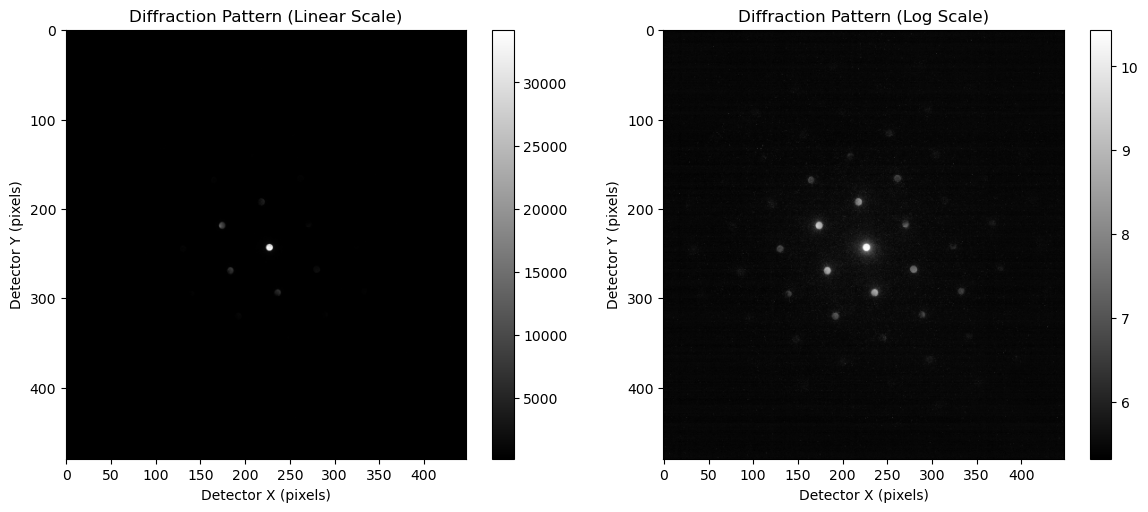


Pattern extracted from scan position (480, 448)


In [214]:
# Extract and display a diffraction pattern from the center of the scan
# Data layout: (Rx, Ry, Qx, Qy) → scan first, diffraction last

# Extract one diffraction pattern from center of scan
diffraction_pattern = dataset.data[10,10,:,:]

print(f"Diffraction pattern shape: {diffraction_pattern.shape}")
print(f"Pattern min: {diffraction_pattern.min()}, max: {diffraction_pattern.max()}")

# Visualize the pattern
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Linear scale
im1 = axes[0].imshow(diffraction_pattern, cmap='gray')
axes[0].set_title('Diffraction Pattern (Linear Scale)')
axes[0].set_xlabel('Detector X (pixels)')
axes[0].set_ylabel('Detector Y (pixels)')
plt.colorbar(im1, ax=axes[0])

# Log scale (often better for seeing weak features)
im2 = axes[1].imshow(np.log1p(diffraction_pattern), cmap='gray')
axes[1].set_title('Diffraction Pattern (Log Scale)')
axes[1].set_xlabel('Detector X (pixels)')
axes[1].set_ylabel('Detector Y (pixels)')
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

print(f"\nPattern extracted from scan position (480, 448)")

## Task 3: Virtual Detector Reconstruction

Generate a Virtual Bright Field (BF) image by integrating the central transmitted disk.

Generate an Annular Dark Field (ADF) image by integrating the scattered electrons in an outer ring.

Compare the Z-contrast in the ADF image to the diffraction contrast in the BF image.

Dataset shape: (17, 77, 480, 448)
Navigation axes (Rx, Ry): (17, 77)
Diffraction axes (Qx, Qy): (480, 448)


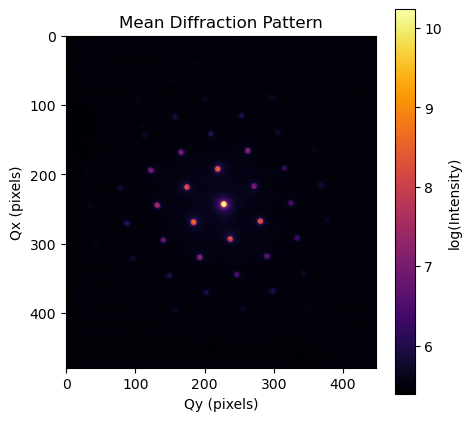

Estimated origin (geometric center):
  x-coordinate: 238.5 pixels
  y-coordinate: 223.0 pixels
Reciprocal space calibration:
  Pixel size: 0.062 1/nm per pixel
  qx range: [-14.788, 14.910] 1/nm
  qy range: [-13.829, 13.885] 1/nm


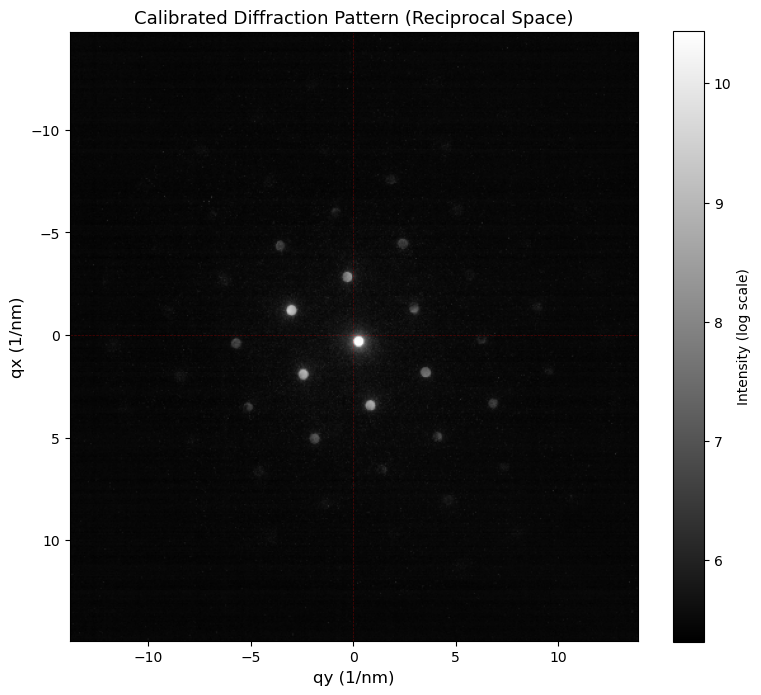

In [241]:
Rx, Ry, Qx, Qy = dataset.data.shape

print("Dataset shape:", dataset.data.shape)
print(f"Navigation axes (Rx, Ry): ({Rx}, {Ry})")
print(f"Diffraction axes (Qx, Qy): ({Qx}, {Qy})")

##-------mean diffraction pattern-------------

mean_dp = np.mean(dataset.data, axis=(0, 1))

plt.figure(figsize=(5, 5))
plt.imshow(np.log(mean_dp + 1), cmap="inferno")
plt.colorbar(label="log(Intensity)")
plt.title("Mean Diffraction Pattern")
plt.xlabel("Qy (pixels)")
plt.ylabel("Qx (pixels)")
plt.show()

# For a symmetric detector, a simple estimate is the geometric center
origin_x = dataset.shape[2] / 2.0 - 1.49
origin_y = dataset.shape[3] / 2.0 - 0.959

print(f"Estimated origin (geometric center):")
print(f"  x-coordinate: {origin_x:.1f} pixels")
print(f"  y-coordinate: {origin_y:.1f} pixels")

# Define reciprocal space calibration
#--------

# Example values (these would be calibrated for your specific setup):
reciprocal_pixel_size = 0.062  # 1/nm per pixel (typical for 200kV STEM)

# Create coordinate arrays (centered at origin)
qx = (np.arange(dataset.shape[2]) - origin_x) * reciprocal_pixel_size
qy = (np.arange(dataset.shape[3]) - origin_y) * reciprocal_pixel_size

print(f"Reciprocal space calibration:")
print(f"  Pixel size: {reciprocal_pixel_size} 1/nm per pixel")
print(f"  qx range: [{qx.min():.3f}, {qx.max():.3f}] 1/nm")
print(f"  qy range: [{qy.min():.3f}, {qy.max():.3f}] 1/nm")

# Visualize the calibrated diffraction pattern
fig, ax = plt.subplots(1, 1, figsize=(8, 7))

im = ax.imshow(np.log1p(diffraction_pattern), 
               extent=[qy.min(), qy.max(), qx.max(), qx.min()],
               cmap='gray', origin='upper')
ax.set_xlabel('qy (1/nm)', fontsize=12)
ax.set_ylabel('qx (1/nm)', fontsize=12)
ax.set_title('Calibrated Diffraction Pattern (Reciprocal Space)', fontsize=13)
ax.axhline(y=0, color='r', linestyle='--', alpha=0.3, linewidth=0.5)
ax.axvline(x=0, color='r', linestyle='--', alpha=0.3, linewidth=0.5)
plt.colorbar(im, ax=ax, label='Intensity (log scale)')
plt.tight_layout()
plt.show()
#----

In [229]:
# Define the real-space pixel size for the scan area

# Example: assuming ~1 Angstrom per pixel (typical high-magnification STEM)
real_pixel_size = 2  # nanometers per pixel

# Create real-space coordinate arrays
# Data shape is (Rx, Ry, Qx, Qy), so scan dimensions are 0 and 1
rx = np.arange(dataset.shape[0]) * real_pixel_size
ry = np.arange(dataset.shape[1]) * real_pixel_size

print(f"Real-space (scan area) calibration:")
print(f"  Pixel size: {real_pixel_size} nm per pixel")
print(f"  Scan width (rx): {rx[-1]:.2f} nm")
print(f"  Scan height (ry): {ry[-1]:.2f} nm")
print(f"  Total scan area: {rx[-1]:.2f} × {ry[-1]:.2f} nm²")

Real-space (scan area) calibration:
  Pixel size: 2 nm per pixel
  Scan width (rx): 32.00 nm
  Scan height (ry): 152.00 nm
  Total scan area: 32.00 × 152.00 nm²


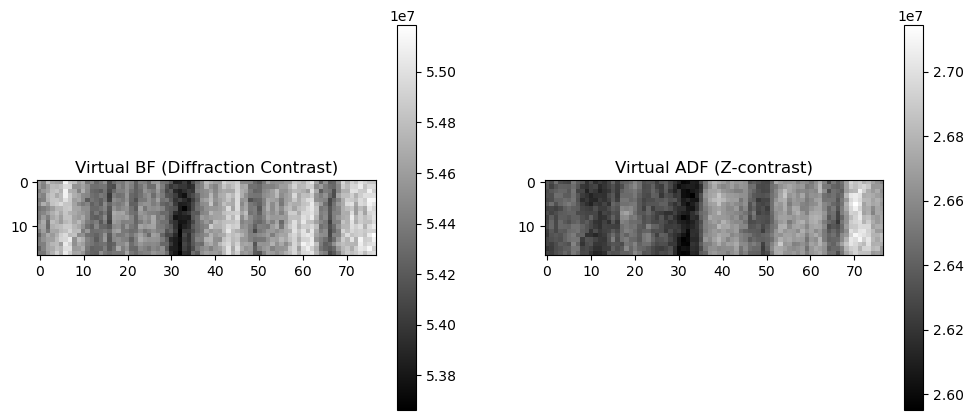

In [263]:
origin_x = dataset.shape[2] / 3.5 
origin_y = dataset.shape[3] / 3.5 

qx = (np.arange(dataset.shape[2]) - origin_x) * reciprocal_pixel_size
qy = (np.arange(dataset.shape[3]) - origin_y) * reciprocal_pixel_size

qx_grid, qy_grid = np.meshgrid(qx, qy, indexing='ij')  # now shapes = (480, 448)
r = np.sqrt(qx_grid**2 + qy_grid**2)

# Define BF and ADF masks (in pixels)
bf_radius = 100
adf_inner = 10
adf_outer = 20

bf_mask = r <= bf_radius
adf_mask = (r >= adf_inner) & (r <= adf_outer)

# Reshape masks for broadcasting: (1,1,Kx,Ky)
bf_mask = (r <= bf_radius)[None, None, :, :]  # shape: (1,1,480,448)
adf_mask = ((r >= adf_inner) & (r <= adf_outer))[None, None, :, :]

# Integrate over masked regions
array = dataset.data  # shape: (17, 77, 480, 448)
bf_image = np.sum(array * bf_mask, axis=(2,3))  # shape: (17, 77)
adf_image = np.sum(array * adf_mask, axis=(2,3))  # shape: (17, 77)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(bf_image, cmap='gray')
plt.title('Virtual BF (Diffraction Contrast)')
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(adf_image, cmap='gray')
plt.title('Virtual ADF (Z-contrast)')
plt.colorbar()
plt.show()

## Task 4: Basic 4D-STEM Visualization

Launch the interactive 4D-STEM browser using dataset.show() (if using a local GUI) or py4D.show_image().

Export a publication-quality figure of a virtual ADF image with a scale bar and a perceptually uniform colormap (e.g., magma).

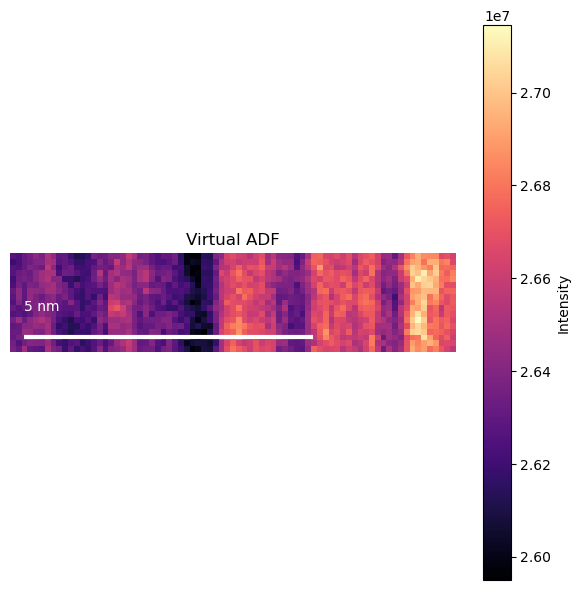

In [264]:
# Your code here
array = dataset.data  # shape: (17,77,480,448)

# Sum over the diffraction (Qx, Qy) axes using the ADF mask
adf_image = np.sum(array * adf_mask, axis=(2,3))  # shape: (17,77)

plt.figure(figsize=(6,6))  # square figure for clarity

# Display virtual ADF
plt.imshow(adf_image, cmap='magma', origin='lower')  # perceptually uniform
plt.title('Virtual ADF')
plt.colorbar(label='Intensity')

# Add scale bar
scale_bar_length_nm = 5  # e.g., 5 nm
pixel_size_nm = 0.1      # from your scan step size
scale_bar_pixels = scale_bar_length_nm / pixel_size_nm

# Draw scale bar
plt.hlines(y=2, xmin=2, xmax=2+scale_bar_pixels, colors='white', linewidth=3)
plt.text(2, 6, f'{scale_bar_length_nm} nm', color='white', fontsize=10, va='bottom')

plt.axis('off')  # remove axes for clean publication figure
plt.tight_layout()

# Save figure
plt.savefig('virtual_adf.png', dpi=300)
plt.show()

## Task 5: Finalize and Submit

Update your README.md with a brief explanation of how virtual detectors allow post-acquisition imaging.

Push the completed Week 02 notebook to your GitHub repository.

Submit the repository link on Canvas.